# Problema 1

**Descripción:**
En este problema, se presenta un conjunto de datos que contiene información sobre el rendimiento académico de estudiantes universitarios, así como diversos factores que podrían influir en él.
El objetivo es construir un modelo de regresión utilizando redes neuronales para predecir el índice de rendimiento académico de los estudiantes basado en las características proporcionadas.
**Dataset:**
El dataset proporcionado incluye las siguientes variables para cada estudiante:
- Hours Studied: El número total de horas dedicadas al estudio por cada estudiante.
- Previous Scores: Las puntuaciones obtenidas por los estudiantes en exámenes previos.
- Extracurricular Activities: Si el estudiante participa en actividades extracurriculares (Sí o No).
- Sleep Hours: El número promedio de horas de sueño que el estudiante tuvo por día.
- Sample Question Papers Practiced: El número de cuestionarios de muestra que el estudiante practicó.

Además, el dataset incluye la variable objetivo:
- Performance Index: Un índice que representa el rendimiento académico general de cada
estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores
más altos indican un mejor rendimiento.

**Objetivo:**
Utilizando el dataset proporcionado, el objetivo es construir un modelo de regresión utilizando redes neuronales que pueda predecir con precisión el índice de rendimiento académico de los estudiantes.

Se debe entrenar y evaluar el modelo utilizando técnicas adecuadas de validación y métricas de evaluación de regresión.

# Preparacion del entorno

## Descarga del dataset

In [29]:
!pip install -q gdown


In [30]:
import gdown

# TP1-1-student_performance.zip
gdown.download('https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc')

Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100%|██████████| 49.7k/49.7k [00:00<00:00, 63.8MB/s]


'TP1-1-student_performance.zip'

In [31]:
import zipfile

with zipfile.ZipFile('TP1-1-student_performance.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-1')

## Importacion de librerias

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Rescaling
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
file_path = '/content/TP1-1/Student_Performance.csv'
df = pd.read_csv(file_path)
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


# Analisis exploratorio de datos
En esta seccion se explora el conjunto de datos con el que se va a trabajar, y se realizan algunas graficas simples de los mismos.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


Vemos que no hay valores NaN y que las variables son numericas exceptuando Extracurricular Activities

In [35]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


Resumen estadistico para ver el comportamiento de las variables y presencias de valores 0 donde no tenga sentido. En este caso no ocurre.

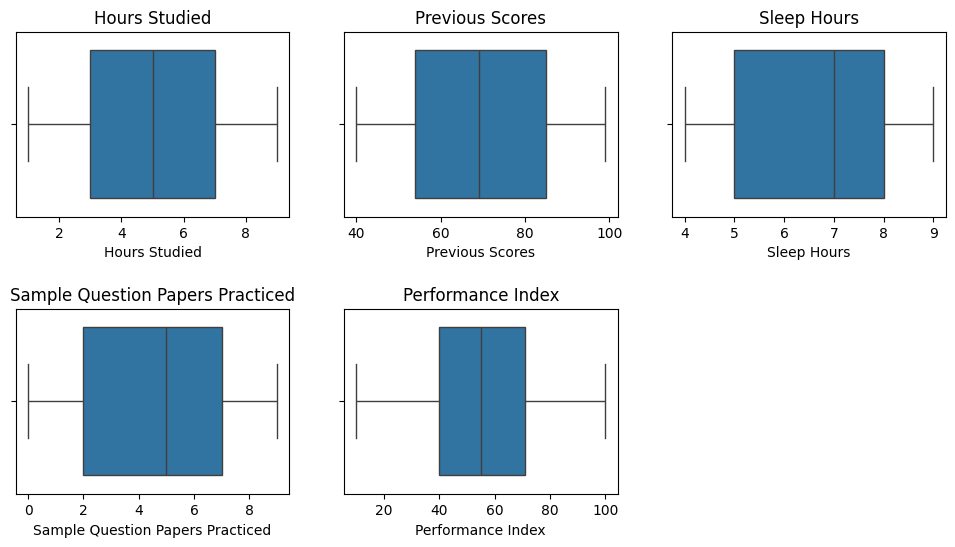

In [36]:

numeric_columns = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']


plt.figure(figsize=(12, 6))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[column])
    plt.title(column)
plt.subplots_adjust(hspace=0.5)

plt.show()


Grafica de cajas para cada variable numerica

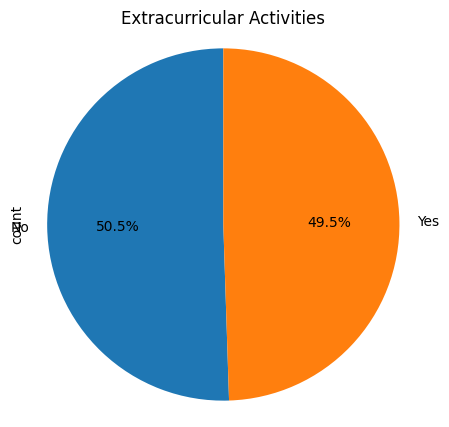

In [37]:
activities_counts = df['Extracurricular Activities'].value_counts()
plt.figure(figsize=(5, 5))
activities_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)


plt.title('Extracurricular Activities')

plt.axis('equal')
plt.show()

Grafica circular para la variable cualitativa Extracurricular Activities

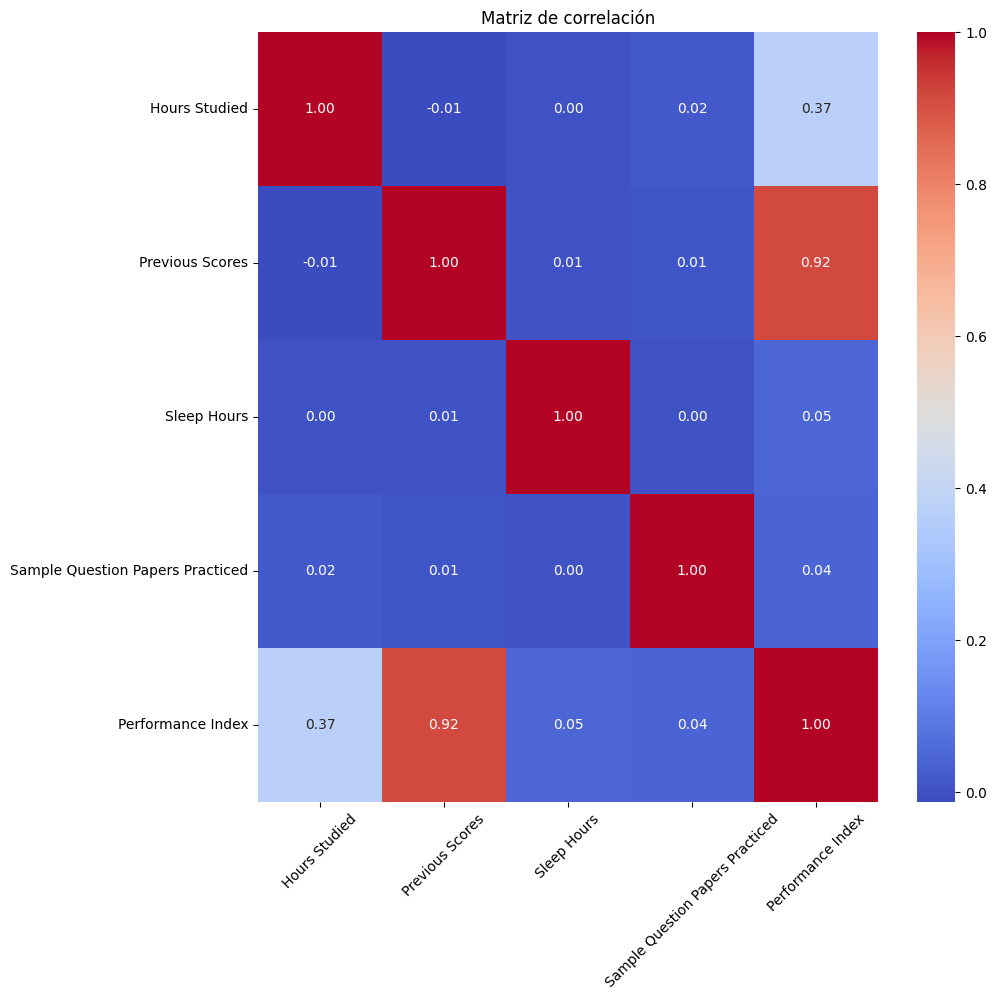

In [38]:
df_numerico =  df.drop('Extracurricular Activities', axis = 1)

# Calcula la matriz de correlación
correlation_matrix = df_numerico.corr()

plt.figure(figsize = (10, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation = 45)
plt.title("Matriz de correlación")
plt.show()

Como comentario general se observa un bajo coeficiente dde correlacion lineal entre nuestra variable objetivo Performance Index y las horas de estudio. La variable Resultados previos si tiene una relacion lineal muy fuerte con respecto a la variable objetivo

# Construccion de la Red neuronal

In [39]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [40]:

df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
# Definir las características (X) y la variable objetivo (y)
X = df.drop(columns=['Performance Index'])  # Características
y = df['Performance Index']  # Variable objetivo

# Normalizar las características
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
# Inspeccionar los datos
print("Número de muestras de entrenamiento:", len(X_train))
print("Número de muestras de validación:", len(X_val))
print("Número de características:", X.shape[1])

Número de muestras de entrenamiento: 8000
Número de muestras de validación: 2000
Número de características: 5


Codificamos la variable no numerica en 0 y 1, y construimos los conjuntos de prueba y entrenamiento, escalando los valores.

In [41]:
def build_model(input_shape):
    i = Input(input_shape)

    x = Dense(128, activation='relu')(i)
    #x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    #x = Dropout(0.3)(x)

    x = Dense(32, activation='relu')(x)
    #x = Dropout(0.3)(x)

    x = Dense(16, activation='relu')(x)

    x = Dense(1)(x)  # Una neurona en la capa de salida para la regresión
    return tf.keras.Model(inputs=[i], outputs=[x])



In [42]:
model = build_model(input_shape=X_train.shape[1:])
# Construir el modelo
print("Construyendo el modelo")
model = build_model(input_shape=X_train.shape[1:])
#optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(
    optimizer='adam',
    loss="mean_squared_error",  # Usamos mean_squared_error para regresión
    #metrics=['mse']
    metrics=['mse', 'mae', 'R2Score']  # Métricas adicionales
)


Construyendo el modelo


In [43]:

# Entrenar el modelo
print("Entrenando el modelo")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)


Entrenando el modelo
Epoch 1/15
250/250 [==============================] - 3s 5ms/step - loss: 674.2729 - mse: 674.2729 - mae: 15.8358 - r2_score: -0.8289 - val_loss: 31.8016 - val_mse: 31.8016 - val_mae: 4.5457 - val_r2_score: 0.9142
Epoch 2/15
250/250 [==============================] - 1s 4ms/step - loss: 16.7262 - mse: 16.7262 - mae: 3.2088 - r2_score: 0.9546 - val_loss: 7.5998 - val_mse: 7.5998 - val_mae: 2.2035 - val_r2_score: 0.9795
Epoch 3/15
250/250 [==============================] - 1s 4ms/step - loss: 5.8284 - mse: 5.8284 - mae: 1.9152 - r2_score: 0.9842 - val_loss: 5.0228 - val_mse: 5.0228 - val_mae: 1.7800 - val_r2_score: 0.9864
Epoch 4/15
250/250 [==============================] - 2s 7ms/step - loss: 4.8405 - mse: 4.8405 - mae: 1.7527 - r2_score: 0.9869 - val_loss: 4.5543 - val_mse: 4.5543 - val_mae: 1.6956 - val_r2_score: 0.9877
Epoch 5/15
250/250 [==============================] - 2s 9ms/step - loss: 4.6195 - mse: 4.6195 - mae: 1.7127 - r2_score: 0.9875 - val_loss: 4.740

# Analisis de los resultados

In [44]:
val_loss, val_mse, val_mae, val_r2 = model.evaluate(X_val, y_val)

#print("Validation Loss:", val_loss)
print(f"Validation MSE:, {val_mse:.4f}")
print(f"Validation MAE:, {val_mae:.4f}")
print(f"Validation R2 Score:, {val_r2:4f}")

63/63 [==============================] - 1s 6ms/step - loss: 4.7507 - mse: 4.7507 - mae: 1.7397 - r2_score: 0.9872
Validation MSE:, 4.7507
Validation MAE:, 1.7397
Validation R2 Score:, 0.987181


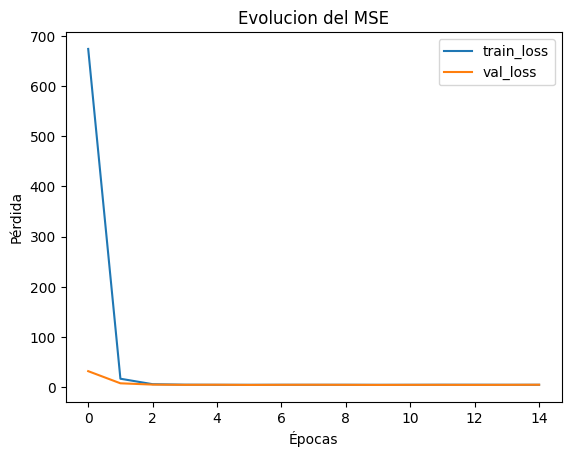

In [56]:

# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolucion del MSE')
plt.legend()
plt.show()

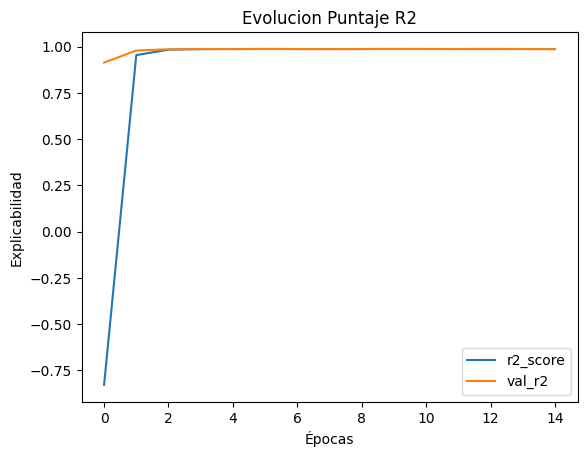

In [55]:

# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['r2_score'], label='r2_score')
plt.plot(history.history['val_r2_score'], label='val_r2')
plt.xlabel('Épocas')
plt.ylabel('Explicabilidad')
plt.title('Evolucion Puntaje R2')
plt.legend()
plt.show()

In [47]:
# Obtener las predicciones del modelo en el conjunto de validación
y_pred = model.predict(X_val)


63/63 [==============================] - 1s 5ms/step


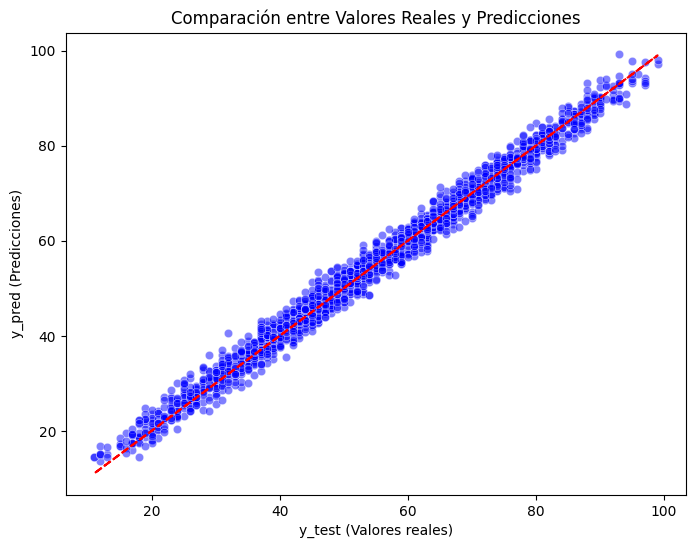

In [48]:
# Crear un DataFrame con los valores reales y las predicciones
comparison_df = pd.DataFrame({'y_test': y_val, 'y_pred': y_pred.flatten()})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=comparison_df, x='y_test', y='y_pred', color='blue', alpha=0.5)
plt.plot(comparison_df['y_test'], comparison_df['y_test'], color='red', linestyle='--')
plt.xlabel('y_test (Valores reales)')
plt.ylabel('y_pred (Predicciones)')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.show()

Los valores se agrupan muy cercanos a la recta donde y_pred=y_val que es lo ideal.

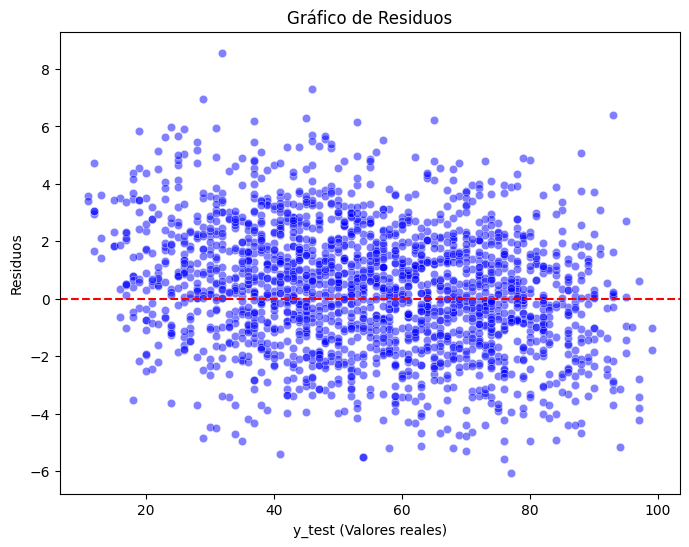

In [49]:
residuals = y_pred.flatten() - y_val

# Crear un DataFrame con los residuos y los valores reales
residuals_df = pd.DataFrame({'Residuals': residuals, 'y_test': y_val})

# Graficar los residuos en función de los valores reales usando Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=residuals_df, x='y_test', y='Residuals', color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Línea horizontal en y=0 para indicar residuos cero
plt.xlabel('y_test (Valores reales)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.show()

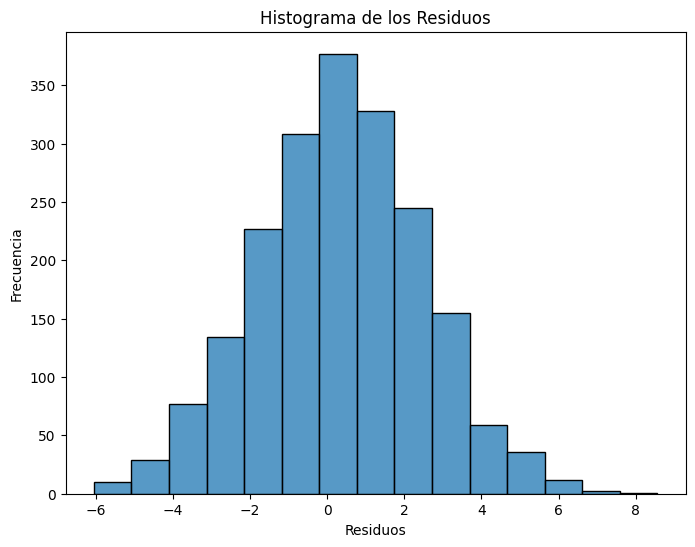

In [54]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=15)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de los Residuos")
plt.show()

No se detectan patrones especiales en la grafica de residuos.

# Conclusiones

Con un modelo sencillo de pocas neuronas obtuvimos como resultado que las variables independientes explican casi la totalidad de la variabilidad de la variable objetivo,alcanzando un R2 de .988 en validacion, y con un error absoluto de 1.7. Excelentes metricas especialmente considerando el minimo costo computacional del modelo neuronal construido.